In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

In [6]:
# Load the CSV dataset
df = pd.read_csv("/content/drive/MyDrive/Song-Lyrics-Generation/data/processed/dataset.csv", index_col=[0])

In [7]:
df = df.sample(n=130000, random_state=42)

In [8]:
# Extract lyrics from the dataset
lyrics = df['Lyric'].tolist()

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df["Lyric"].astype(str).str.lower())
total_words = len(tokenizer.word_index) + 1
tokenized_sentences = tokenizer.texts_to_sequences(df["Lyric"].astype(str))

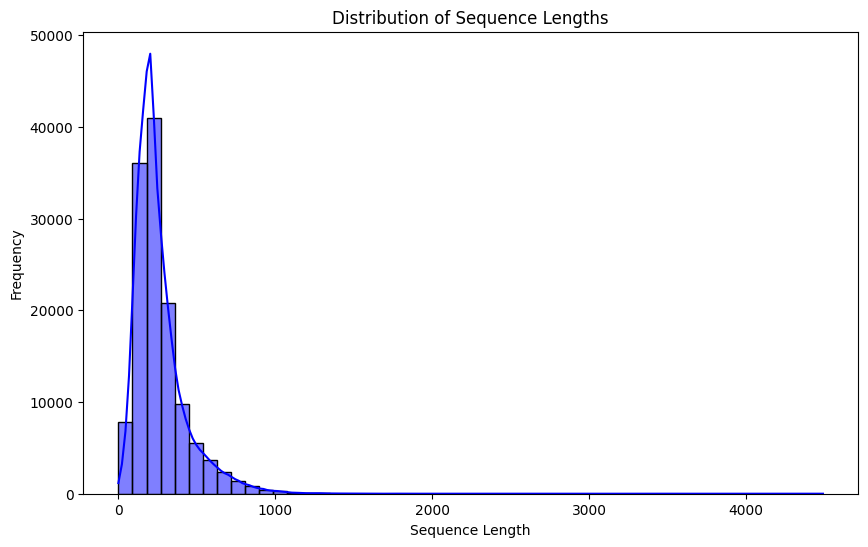

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

sequence_lengths = [len(seq) for seq in tokenized_sentences]

# Plot a histogram
plt.figure(figsize=(10, 6))
sns.histplot(sequence_lengths, bins=50, kde=True, color='blue')
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()

In [10]:
from collections import Counter

# Assuming you have already computed sequence_lengths
sequence_lengths = [len(seq) for seq in tokenized_sentences]

# Use Counter to count the occurrences of each sequence length
length_counts = Counter(sequence_lengths)

# Find the most common sequence length
most_common_length, frequency = length_counts.most_common(1)[0]

print(f"The most common sequence length is: {most_common_length}, with a frequency of: {frequency} occurrences.")


The most common sequence length is: 206, with a frequency of: 645 occurrences.


In [11]:
maxlen = 200  # Set your desired maximum sequence length

# Pad or truncate sequences
padded_sequences = pad_sequences(tokenized_sentences, maxlen=maxlen, padding='pre')

In [12]:
# Split the data into training and testing sets
X_train, X_val = train_test_split(padded_sequences, test_size=0.2, random_state=42)


In [13]:
# Standardize the input data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [14]:
# Define VAE parameters
latent_dim = 32
intermediate_dim = 256
epsilon_std = 1.0
embedding_dim = 100
num_latent_vars = 3

In [15]:
# Reparameterization trick
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim), mean=0., stddev=epsilon_std)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [16]:
# Encoder
inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, input_length=maxlen)(inputs)
flatten_layer = Flatten()(embedding_layer)
h = Dense(intermediate_dim, activation='relu')(flatten_layer)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

In [17]:
# Sample z using reparameterization trick
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [18]:
# Decoder
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(maxlen, activation='sigmoid')

h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

In [19]:
from keras.layers import Layer
from keras.losses import binary_crossentropy
from keras import backend as K

class CustomVariationalLayer(Layer):
    def vae_loss(self, x, x_decoded_mean, z_mean, z_log_var):
        xent_loss = maxlen * binary_crossentropy(x, x_decoded_mean)
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean = inputs[1]
        z_mean = inputs[2]
        z_log_var = inputs[3]
        loss = self.vae_loss(x, x_decoded_mean, z_mean, z_log_var)
        self.add_loss(loss, inputs=inputs)
        return x

In [20]:
# Instantiate VAE model
y = CustomVariationalLayer()([inputs, x_decoded_mean, z_mean, z_log_var])
vae = Model(inputs, y)

In [24]:
# Compile the model
vae.compile(optimizer=Adam(learning_rate=0.00001), loss=None)

In [3]:
import wandb
wandb.login(key="")
run = wandb.init(project="Training variational autoencoder for Lyrics Generation", job_type="training", anonymous="allow")

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: kokeza-lara (timneuronske). Use `wandb login --relogin` to force relogin


In [25]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False)
wandb_callback = wandb.keras.WandbCallback()

In [28]:
history = vae.fit(X_train, epochs=10, batch_size=512, validation_data=(X_val, None), callbacks=[early_stopping, tensorboard, wandb_callback])

Epoch 1/10
204/204 [==============================] - ETA: 0s - loss: 119.7418

wandb: Adding directory to artifact (/content/wandb/run-20240114_231225-n2k8zxv0/files/model-best)... Done. 2.1s


204/204 [==============================] - 205s 1s/step - loss: 119.7418 - val_loss: 108.9354
Epoch 2/10
204/204 [==============================] - ETA: 0s - loss: 97.2424

wandb: Adding directory to artifact (/content/wandb/run-20240114_231225-n2k8zxv0/files/model-best)... Done. 2.5s


204/204 [==============================] - 192s 942ms/step - loss: 97.2424 - val_loss: 84.2304
Epoch 3/10
204/204 [==============================] - ETA: 0s - loss: 73.9646

wandb: Adding directory to artifact (/content/wandb/run-20240114_231225-n2k8zxv0/files/model-best)... Done. 3.9s


204/204 [==============================] - 188s 922ms/step - loss: 73.9646 - val_loss: 62.5379
Epoch 4/10
204/204 [==============================] - ETA: 0s - loss: 54.0101

wandb: Adding directory to artifact (/content/wandb/run-20240114_231225-n2k8zxv0/files/model-best)... Done. 3.5s


204/204 [==============================] - 201s 985ms/step - loss: 54.0101 - val_loss: 44.0916
Epoch 5/10
204/204 [==============================] - ETA: 0s - loss: 37.1405

wandb: Adding directory to artifact (/content/wandb/run-20240114_231225-n2k8zxv0/files/model-best)... Done. 1.4s


204/204 [==============================] - 193s 946ms/step - loss: 37.1405 - val_loss: 28.3100
Epoch 6/10
204/204 [==============================] - ETA: 0s - loss: 22.4574

wandb: Adding directory to artifact (/content/wandb/run-20240114_231225-n2k8zxv0/files/model-best)... Done. 1.8s


204/204 [==============================] - 187s 917ms/step - loss: 22.4574 - val_loss: 14.9323
Epoch 7/10
204/204 [==============================] - ETA: 0s - loss: 9.6299

wandb: Adding directory to artifact (/content/wandb/run-20240114_231225-n2k8zxv0/files/model-best)... Done. 5.0s


204/204 [==============================] - 199s 975ms/step - loss: 9.6299 - val_loss: 2.6712
Epoch 8/10
204/204 [==============================] - ETA: 0s - loss: -2.4090

wandb: Adding directory to artifact (/content/wandb/run-20240114_231225-n2k8zxv0/files/model-best)... Done. 1.3s


204/204 [==============================] - 185s 904ms/step - loss: -2.4090 - val_loss: -9.4150
Epoch 9/10
204/204 [==============================] - ETA: 0s - loss: -15.3273

wandb: Adding directory to artifact (/content/wandb/run-20240114_231225-n2k8zxv0/files/model-best)... Done. 3.4s


204/204 [==============================] - 190s 926ms/step - loss: -15.3273 - val_loss: -23.4736
Epoch 10/10
204/204 [==============================] - ETA: 0s - loss: -31.0467

wandb: Adding directory to artifact (/content/wandb/run-20240114_231225-n2k8zxv0/files/model-best)... Done. 1.2s


204/204 [==============================] - 198s 969ms/step - loss: -31.0467 - val_loss: -41.9504


In [29]:
vae.save("variational_autoencoder.h5")

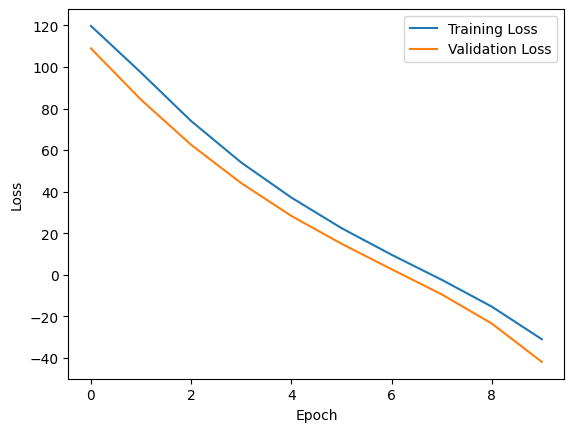

In [30]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

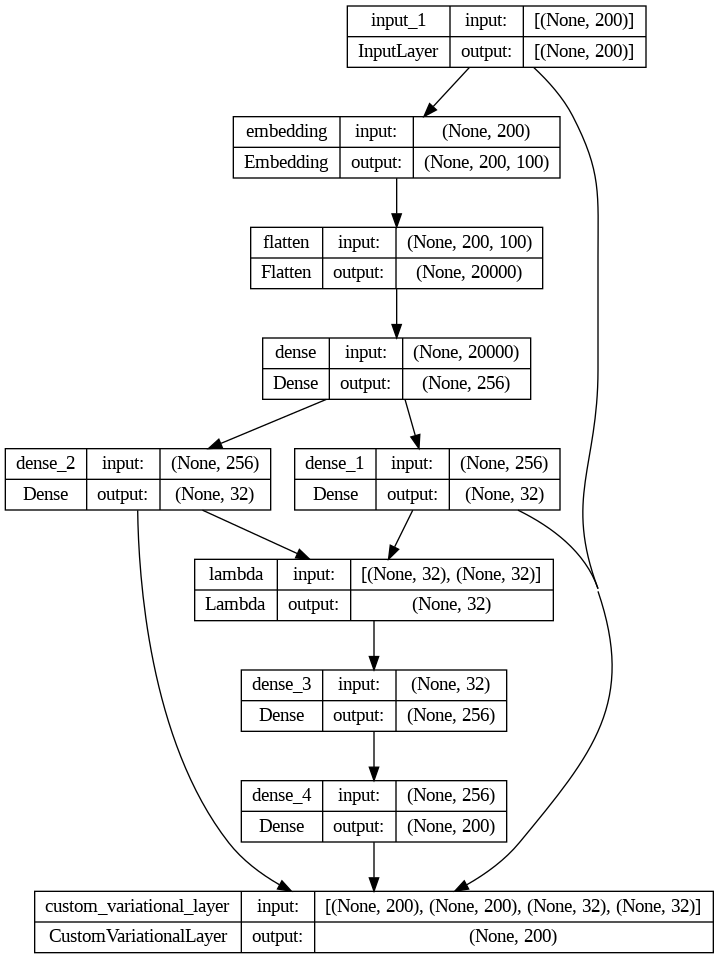

In [31]:
from tensorflow.keras.utils import plot_model

plot_model(vae, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [51]:
def generate_lyric_vae_with_seed(vae, tokenizer, seed_text, maxlen=200, n_words=50, temperature=1.0):
    """
    Generate lyrics using a Variational Autoencoder (VAE) with a seed text.

    Parameters:
    - vae: The trained VAE model.
    - tokenizer: Keras Tokenizer used for text sequences.
    - seed_text: The seed text for generating the lyrics.
    - maxlen: Maximum sequence length.
    - n_words: Number of words to generate.
    - temperature: Parameter controlling the randomness of the generation.

    Returns:
    - generated_lyric: The generated lyrics.
    """

    # Tokenize the seed text
    seed_sequence = tokenizer.texts_to_sequences([seed_text])[0]
    seed_padded = pad_sequences([seed_sequence], maxlen=maxlen, padding='pre', truncating='pre')

    # Generate new lyrics word by word
    generated_lyric = seed_text
    for _ in range(n_words):
        # Predict the next word based on the seed text
        predicted = vae.predict(seed_padded, verbose=0)[0]

        # Apply temperature to the predicted logits
        predicted = np.log(predicted) / temperature
        exp_preds = np.exp(predicted)
        predicted_probs = exp_preds / np.sum(exp_preds)

        # Sample from the predicted distribution
        next_index = np.argmax(np.random.multinomial(1, predicted_probs, 1)) + 1

        # Convert the index back to text
        decoded_lyric_text = tokenizer.sequences_to_texts([[next_index]])[0]

        # Update the seed text for the next iteration
        seed_text += " " + decoded_lyric_text
        seed_sequence = tokenizer.texts_to_sequences([seed_text])[0]
        seed_padded = pad_sequences([seed_sequence], maxlen=maxlen, padding='pre', truncating='pre')

        # Update the generated lyric
        generated_lyric += " " + decoded_lyric_text

    return generated_lyric

In [53]:
# Example usage:
seed_text = "When you were here before Couldn't look you in the eye"
generated_lyric = generate_lyric_vae_with_seed(vae, tokenizer, seed_text, n_words=20, temperature=0.2)
print("Generated Lyric:\n", generated_lyric)

<ipython-input-51-043e255bbfa9>:28: RuntimeWarning: divide by zero encountered in log
  predicted = np.log(predicted) / temperature


Generated Lyric:
 When you were here before Couldn't look you in the eye end lyrics left fall should real last people people inside boy god made another show hard fuck going face alone
